In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

In [38]:
df = pd.read_excel('/content/Dados Agricultura Atualizados.xlsx')


In [39]:
pd.to_datetime(df['Data'])
df = df.set_index('Data')


In [40]:
df.head()

,x_cafe,REER,RENDA_INDEX,AGRI_INDEX
Data,,,,
2004-01-01,1131.772,55.67333,1.075363e+06,748063781435012
2004-04-01,1235.236,54.09000,1.082784e+06,784075632985555
2004-07-01,1226.302,55.92000,1.086752e+06,725786230035456
2004-10-01,1339.009,58.70000,1.092146e+06,731431735263002
2005-01-01,1683.448,61.37000,1.091991e+06,783138795587763


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2004-01-01 to 2021-10-01
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   x_cafe       72 non-null     float64
 1   REER         72 non-null     float64
 2   RENDA_INDEX  72 non-null     float64
 3   AGRI_INDEX   72 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 2.8 KB


In [42]:
df.describe()

,x_cafe,REER,RENDA_INDEX,AGRI_INDEX
count,72.000000,72.000000,7.200000e+01,7.200000e+01
mean,2582.257292,72.879102,1.287932e+06,4.178229e+14
std,746.865553,22.551861,1.225664e+05,3.909308e+14
min,1131.772000,10.117000,1.075363e+06,1.058623e+13
25%,2145.659750,65.597503,1.209430e+06,1.051809e+14
50%,2484.681500,77.390000,1.257752e+06,1.235752e+14
75%,2853.153250,86.425830,1.381377e+06,8.528795e+14
max,4778.319000,99.953330,1.569814e+06,9.941568e+14


In [43]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(68, 4)
(4, 4)


In [44]:
AGRI_INDEX = df_train['AGRI_INDEX']
x_cafe = df_train['x_cafe']
REER = df_train['REER']
RENDA_INDEX = df_train['RENDA_INDEX']



Text(0.5, 1.0, 'Preço de café')

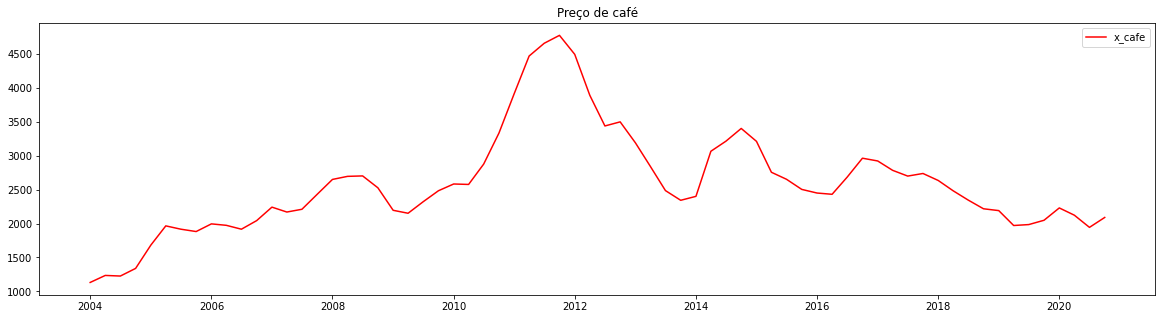

In [45]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(x_cafe, color='red', label='x_cafe')
plt.legend(loc='best')
plt.title('Preço de café')

Text(0.5, 1.0, 'x_cafe, Média e Desvio Padrão')

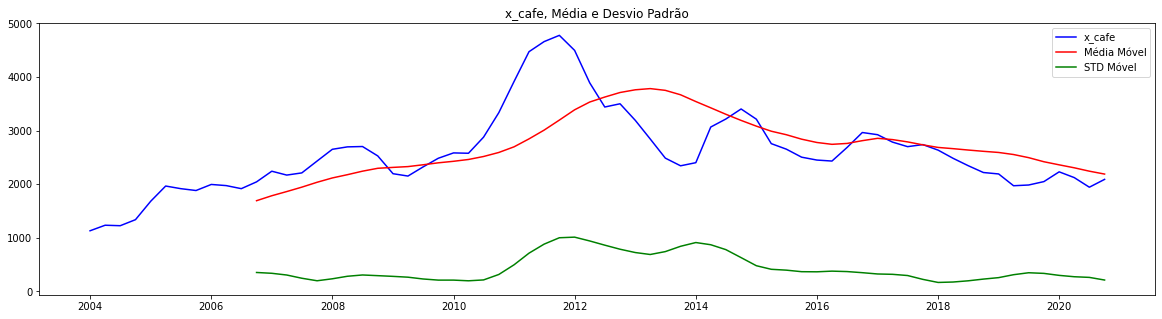

In [46]:
rolmean = x_cafe.rolling(window=12).mean() 
rolstd = x_cafe.rolling(window=12).std()
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(x_cafe, color='blue', label='x_cafe')
plt.plot(rolmean, color='red', label='Média Móvel')
plt.plot(rolstd, color='green', label='STD Móvel')
plt.legend(loc='best')
plt.title('x_cafe, Média e Desvio Padrão')

Text(0.5, 1.0, 'Índice de Renda')

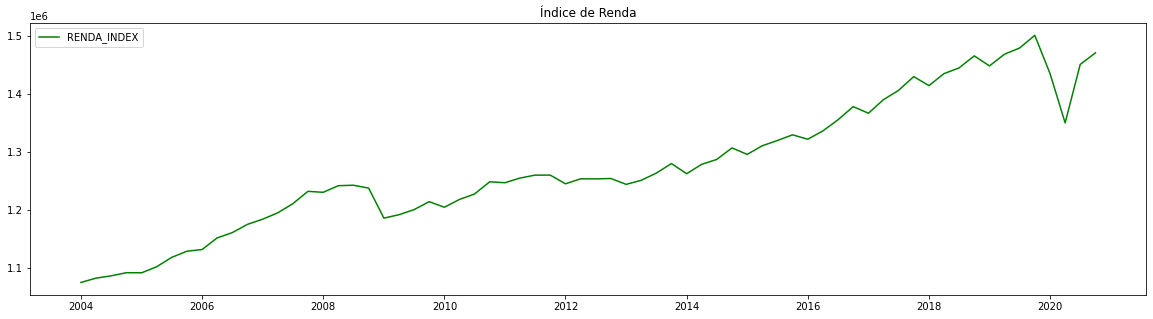

In [47]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(RENDA_INDEX, color='green', label='RENDA_INDEX')
plt.legend(loc='best')
plt.title('Índice de Renda')

Text(0.5, 1.0, 'índice de Agricultura')

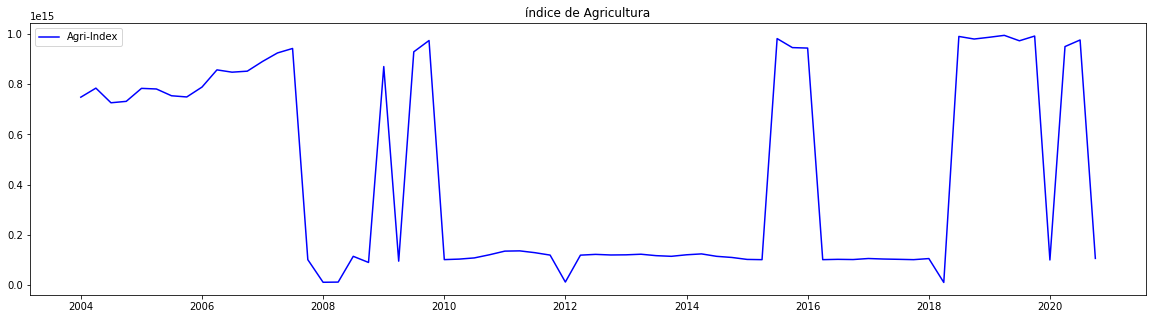

In [48]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(AGRI_INDEX, color='blue', label='Agri-Index')
plt.legend(loc='best')
plt.title('índice de Agricultura')

Text(0.5, 1.0, 'Taxa de Câmbio Real Efetiva')

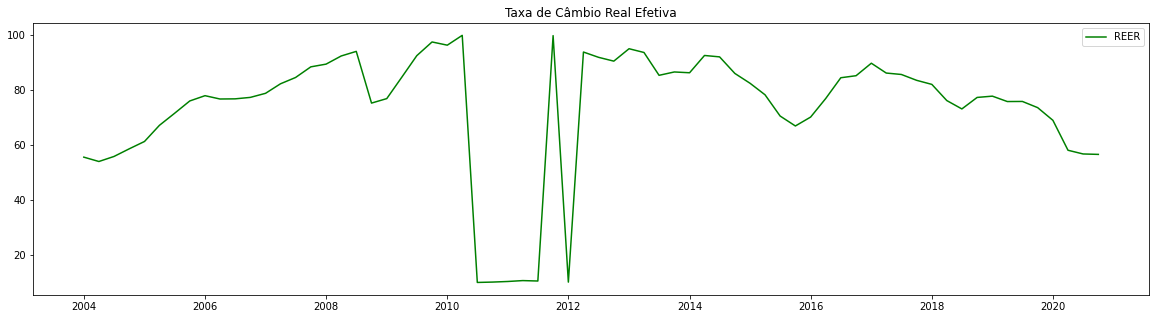

In [49]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(REER, color='green', label='REER')
plt.legend(loc='best')
plt.title('Taxa de Câmbio Real Efetiva')

In [50]:
def test_stationarity_adf(timeseries):
    
       
       #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [51]:
def test_stationarity_kpss(timeseries):
           
    #Perform KPSS test:
    print('Results of KPSS Test:')
    kpsstest = kpss(timeseries)
    kpssoutput = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used', ])
    for key,value in kpsstest[3].items():
        kpssoutput['Critical Value (%s)'%key] = value
    return kpssoutput

In [52]:
test_stationarity_adf(x_cafe)

Results of Dickey Fuller Test:


Test Statistic                 -2.909299
p-value                         0.044277
#Lags Used                      1.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64

In [53]:
test_stationarity_kpss(x_cafe)

Results of KPSS Test:


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Test Statistic            0.201125
p-value                   0.100000
#Lags Used               11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [54]:
test_stationarity_adf(RENDA_INDEX)

Results of Dickey Fuller Test:


Test Statistic                 -1.567032
p-value                         0.500130
#Lags Used                      4.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64

In [55]:
test_stationarity_kpss(RENDA_INDEX)

Results of KPSS Test:


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


Test Statistic            0.660555
p-value                   0.017131
#Lags Used               11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [56]:
test_stationarity_adf(AGRI_INDEX)

Results of Dickey Fuller Test:


Test Statistic                 -3.979206
p-value                         0.001523
#Lags Used                      0.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64

In [57]:
test_stationarity_kpss(AGRI_INDEX)

Results of KPSS Test:


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Test Statistic            0.195106
p-value                   0.100000
#Lags Used               11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [58]:
test_stationarity_adf(REER)

Results of Dickey Fuller Test:


Test Statistic                 -2.642587
p-value                         0.084511
#Lags Used                      5.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64

In [59]:
test_stationarity_kpss(REER)

Results of KPSS Test:


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Test Statistic            0.081007
p-value                   0.100000
#Lags Used               11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [60]:
df_train['x_cafe'] = x_cafe.diff()
df_train['AGRI_INDEX'] = AGRI_INDEX.diff()
df_train['RENDA_INDEX'] = RENDA_INDEX.diff()
df_train['REER'] = REER.diff()

df_train = df_train.dropna()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [61]:
df_train

,x_cafe,REER,RENDA_INDEX,AGRI_INDEX
Data,,,,
2004-04-01,103.464,-1.58333,7421.508458,3.601185e+13
2004-07-01,-8.934,1.83000,3968.294272,-5.828940e+13
2004-10-01,112.707,2.78000,5393.299752,5.645505e+12
2005-01-01,344.439,2.67000,-154.700188,5.170706e+13
2005-04-01,283.225,5.86667,10285.209580,-2.459595e+12
...,...,...,...,...
2019-10-01,63.595,-2.25000,21892.393136,1.880195e+13
2020-01-01,182.025,-4.61666,-65903.449116,-8.912730e+14
2020-04-01,-107.357,-10.87667,-84964.720518,8.494510e+14


In [62]:
model = VAR(df_train)
for i in [1, 2, 3]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  103.683819690488
BIC :  104.347351430496
FPE :  1.0710655040436402e+45
HQIC:  103.94601261780188 

Lag Order = 2
AIC :  103.84600601766623
BIC :  105.05028204406997
FPE :  1.2672359801709837e+45
HQIC:  104.32117011274015 

Lag Order = 3
AIC :  103.83995632616941
BIC :  105.59404883139915
FPE :  1.2795984246362277e+45
HQIC:  104.5309819677198 



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [63]:
x = model.select_order(maxlags=10)
x.summary()

,AIC,BIC,FPE,HQIC
0,104.8,104.9*,3.171e+45,104.8
1,104.2,105.0,1.862e+45,104.5*
2,104.4,105.7,2.208e+45,104.9
3,104.3,106.2,2.055e+45,105.0
4,104.6,107.0,2.837e+45,105.5
5,104.4,107.4,2.444e+45,105.5
6,104.1,107.7,2.171e+45,105.5
7,104.4,108.6,3.492e+45,106.1
8,104.4,109.1,4.117e+45,106.2
9,103.9,109.2,3.528e+45,105.9


In [74]:
model = VAR(df_train)
results = model.fit(1)



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [75]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, May, 2022
Time:                     19:24:46
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    104.347
Nobs:                     66.0000    HQIC:                   103.946
Log likelihood:          -3776.17    FPE:                1.07107e+45
AIC:                      103.684    Det(Omega_mle):     7.99758e+44
--------------------------------------------------------------------
Results for equation x_cafe
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -5.753632        25.081972           -0.229           0.819
L1.x_cafe              0.556579         0.103108            5.398           0.000
L1.REER               -0.551715         1.101889       

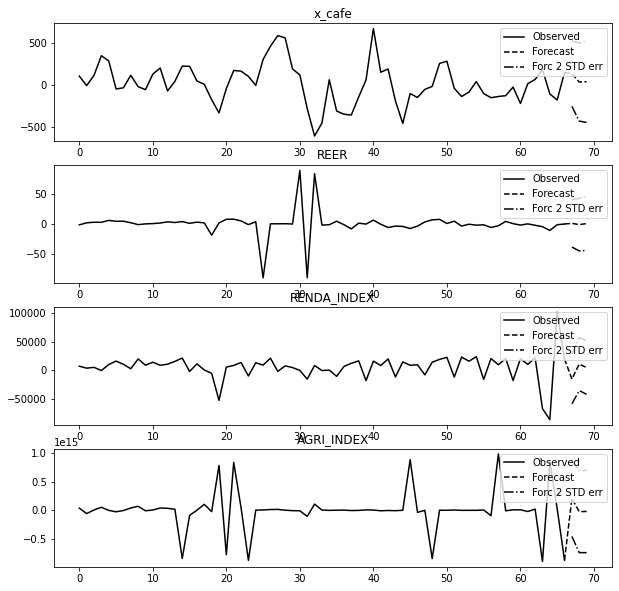

In [78]:
results.plot_forecast(3)
plt.legend=()

In [79]:
lag_order = results.k_ar
print(lag_order)

1


In [83]:
forecast_input = df_train.values[-lag_order:]
forecast_input

array([[ 1.46261000e+02, -1.56670000e-01,  1.99880423e+04,
        -8.69440256e+14]])

In [86]:
fc = results.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,x_cafe_1d,REER_1d,RENDA_INDEX_1d,AGRI_INDEX_1d
Data,,,,
2021-01-01,132.689002,0.925356,-14863.425637,2.066126e+14
2021-04-01,32.857724,-1.173208,11045.995098,-2.495782e+13
2021-07-01,36.764670,0.539329,5033.563431,-2.105629e+13
2021-10-01,25.325585,-0.279043,5245.451650,-4.307258e+12


In [69]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        #if second_diff:
            #df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [70]:
#df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
#df_results.loc[:, ['x_cafe_forecast', 'REER_forecast', 'RENDA_INDEX_forecast', 'AGRI_INDEX_forecast']]

In [71]:
#df_test

In [72]:
#df_test.diff().dropna()

In [73]:
#fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
#for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    #df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    #df_test.diff()[col][-nobs:].plot(legend=True, ax=ax);
    #ax.set_title(col + ": Forecast vs Actuals")
    #ax.xaxis.set_ticks_position('none')
    #ax.yaxis.set_ticks_position('none')
    #ax.spines["top"].set_alpha(0)
    #ax.tick_params(labelsize=6)

#plt.tight_layout();